In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model
from geneticalgorithm2 import Generation, AlgorithmParams # classes for comfortable parameters setting and getting
from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior


In [2]:
use_minmax_data = False

In [3]:
if use_minmax_data:
    # Load data into pandas DataFrame
    df = pd.read_parquet("dataset/minmaxscaled_train_data.parquet")
else:
    # Load data into pandas DataFrame
    df = pd.read_parquet("dataset/scaled_train_data.parquet")
classes = df["class"].unique()
#hard move data, so it's positive thus cosine measurements clamped to [0,1]
df.loc[:,df.columns != 'class'] -= df.loc[:,df.columns != 'class'].min()

MO_list = [df[df["class"] == c].mean(axis=0)[:-1].to_numpy() for c in classes ]

In [4]:
#only allow values in the original value range
#this is higly questionable
boundaries = [(min,max) for min,max in zip(df.min()[:-1],df.max()[:-1])]

In [5]:
#class 0 = sitting, all the others are opposing
parameter_c = .4

def cos_measure(s:np.ndarray,t:np.ndarray):
    return np.dot(s,t)/(np.linalg.norm(s) *np.linalg.norm(t))


def F(s:np.ndarray):
    oppose_avg = 1 - (cos_measure(s,MO_list[1])+cos_measure(s,MO_list[2])+cos_measure(s,MO_list[3])+cos_measure(s,MO_list[4]))/4.
    num = cos_measure(s,MO_list[0]) + parameter_c * oppose_avg
    denom = 1. + parameter_c
    return (num)/denom

def costF(s:np.ndarray):
    return -F(s)

In [6]:
class Crossover(Crossover):
    #override original uniform function with bias
    @staticmethod
    def uniform(bias:float = 0.5):
        
        def func(x, y):
            ofs1, ofs2 = x.copy(),y.copy()
        
            ran = np.random.random(x.size) < bias
            ofs1[ran] = y[ran]
            ofs2[ran] = x[ran]
              
            return ofs1, ofs2
        
        return func
    


Set: Average time of function evaluating (secs): 3.002643585205078e-05 (total = 0.003002643585205078)

Best score before optimization: -0.7033032174324606
                                                                                                                                                                                                        
 The best found solution:
 [27.04593117 14.44508151 15.31102427  2.73481679  2.39024391  2.34000973
  9.79878327 11.27536546 11.32762784 16.06159381 20.04067937 28.11483863]

 Objective function:
 -0.7147861163021914

 Used generations: 53
 Used time: 0.383 seconds


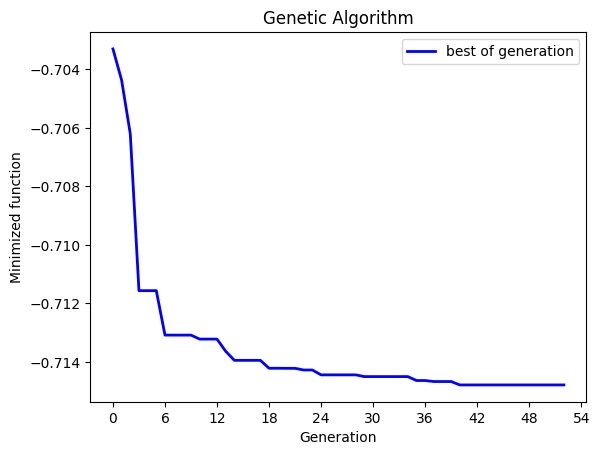

In [7]:
GA_modell = ga(costF,
                dimension=12,
                    variable_type=('real'),
                    variable_boundaries=boundaries,
                    algorithm_parameters=AlgorithmParams(
                        max_num_iteration = 1000,
                        max_iteration_without_improv=10,
                        population_size = 100,
                        mutation_probability = 0.1,
                        #elit_ratio = 0.01,
                        parents_portion = 0.3,
                        crossover_type = Crossover.mixed(alpha=.6),
                        #crossover_type = Crossover.uniform(bias=.6),
                        mutation_type = 'uniform_by_center',
                        selection_type = 'roulette',
                        #selection_type = Selection.tournament(tau=4),
                        ))
    # all of this parameters are default
results = GA_modell.run()

In [8]:
# best solution
print(" best score:",F(results.variable))

for i in range(5):
    print(f"cosine({i}):",cos_measure(results.variable,MO_list[i]))


 best score: 0.7147861163021914
cosine(0): 0.9991702036772946
cosine(1): 0.9962442447814648
cosine(2): 0.9966038699805241
cosine(3): 0.9961149636395704
cosine(4): 0.9957333301407081


In [9]:
test_matrice = [
    {"pop_size":20,"crossover_prob":.6,"mutation_prob":0.},
    {"pop_size":20,"crossover_prob":.6,"mutation_prob":0.01},
    {"pop_size":20,"crossover_prob":.6,"mutation_prob":0.1},
    {"pop_size":20,"crossover_prob":.9,"mutation_prob":0.01},
    {"pop_size":20,"crossover_prob":.9,"mutation_prob":0.01},
    {"pop_size":200,"crossover_prob":.6,"mutation_prob":0.},
    {"pop_size":200,"crossover_prob":.6,"mutation_prob":0.01},
    {"pop_size":200,"crossover_prob":.6,"mutation_prob":0.1},
    {"pop_size":200,"crossover_prob":.9,"mutation_prob":0.01},
    {"pop_size":200,"crossover_prob":.9,"mutation_prob":0.01},
]

In [10]:
for testcase in test_matrice:
    results = []
    reports = []
    testcase["result"] = []
    for _ in range(10):
        GA_modell = ga(costF,
                    dimension=12,
                        variable_type=('real'),
                        variable_boundaries=boundaries,
                        algorithm_parameters=AlgorithmParams(
                            max_num_iteration = 1000,
                            max_iteration_without_improv=20,
                            population_size = testcase['pop_size'],
                            mutation_probability = testcase['mutation_prob'],
                            #elit_ratio = 0.01,
                            parents_portion = 0.4,
                            #crossover_type = Crossover.mixed(alpha=.6),
                            crossover_type = Crossover.uniform(bias=testcase['crossover_prob']),
                            mutation_type = 'uniform_by_center',
                            selection_type = 'roulette',
                            #selection_type = Selection.tournament(tau=4),
                            ))
        # all of this parameters are default
        results.append(GA_modell.run(no_plot=True,disable_printing=True))
        reports.append(GA_modell.report.copy())
    testcase["results"] = results
    testcase["reports"] = reports

|||||_______________ 25.4% GA is running... STOP! limit of fails: 21value = -0.7148492685761867

In [11]:
for tcase in test_matrice:
    #print(f"pop: {tcase['pop_size']}, mut:{tcase['mutation_prob']}, crosl:{tcase['crossover_prob']}")
    reslist = tcase['results']
    replist = tcase['reports']
    best_avg = np.average([r.score for r in reslist])
    iteration_size = np.average([len(r) for r in replist])
    #print(f"average_score: {-best_avg:.4f} average_iteration: {iteration_size}")
    #print(tcase['pop_size'],'\t',tcase['crossover_prob'],'\t',tcase['mutation_prob'],'\t',f"{-best_avg:.4f}",'\t',iteration_size)
    

In [16]:
for i,tcase in enumerate(test_matrice):
    plt.figure()
    label = f"pop: {tcase['pop_size']}, mut:{tcase['mutation_prob']}, crosl:{tcase['crossover_prob']}"
    ms = np.max([len(r) for r in tcase['reports']])

    line_data = [np.pad(r,(0,ms-len(r)),'edge') for r in tcase['reports']]

    # Calculate the average line and standard deviation
    average_line = np.mean(line_data, axis=0)
    std_dev = np.std(line_data, axis=0)

    # Create x-values for the plot
    x_values = range(1, len(average_line) + 1)

    # Plot the average line
    plt.plot(x_values, average_line, label='Average Line')

    # Plot the error band
    plt.fill_between(x_values, average_line - std_dev, average_line + std_dev, alpha=0.3, label='Error Band')


    # Set labels and title
    plt.xlabel('iteration count')
    plt.ylabel('negative score')
    plt.title(label)

    # Display the legend
    plt.legend()

    # Show the plot
    plt.savefig(f"media/plt{i}.png")
    plt.close()

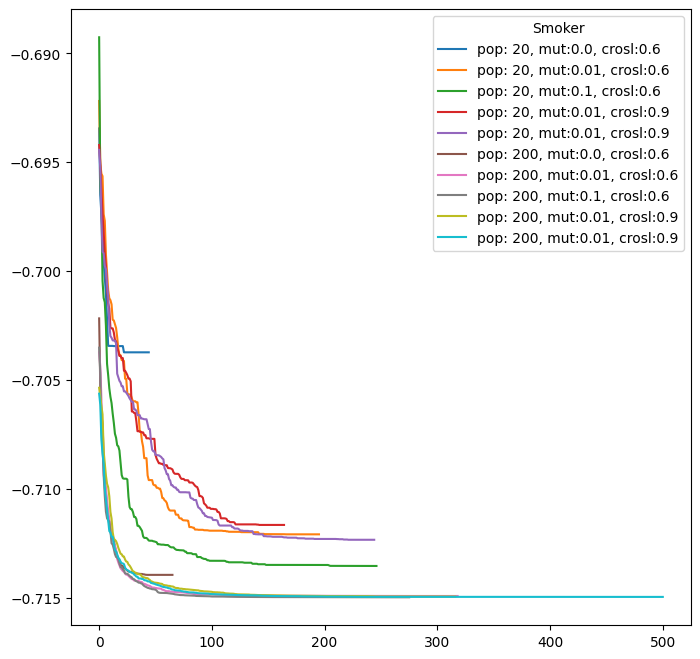

In [14]:
import pandas as pd
average_list = []
label_list = []
for tcase in test_matrice:
    label = f"pop: {tcase['pop_size']}, mut:{tcase['mutation_prob']}, crosl:{tcase['crossover_prob']}"
    label_list.append(label)
    ms = np.max([len(r) for r in tcase['reports']])

    line_data = [np.pad(r,(0,ms-len(r)),'edge') for r in tcase['reports']]

    # Calculate the average line and standard deviation
    average_line = np.mean(line_data, axis=0)
    average_list.append(average_line)


plt.figure(figsize=(8,8))
sns.lineplot(average_list,dashes=False,legend=False,errorbar=None)
plt.legend(title='Smoker', loc='upper right', labels=label_list)